# Анализ и прогнозирование потребления алкоголя студентами
## Учебный исследовательский проект

## 1. Цель работы

Разработать модель машинного обучения для прогнозирования уровня потребления алкоголя студентами на основе их социально-демографических характеристик, академических показателей и семейных факторов. Задача имеет практическую значимость для образовательных учреждений и социальных служб в выявлении групп риска и разработке профилактических мер.

## 2. Описание исходных данных

**Источник данных:** Набор данных "Student Alcohol Consumption" с платформы HuggingFace Datasets

**Структура данных:**
- 395 наблюдений (студентов)
- 33 признака, включая:
  - Демографические: возраст, пол, тип семьи, размер семьи
  - Социальные: время с друзьями, отношения с семьей, поддержка родителей
  - Академические: оценки, посещаемость, дополнительные занятия
  - Целевые переменные: потребление алкоголя в будни и выходные

**Ключевые характеристики:**
- Данные собраны в португальских школах
- Содержит как числовые, так и категориальные признаки
- Имеет некоторый дисбаланс классов

In [1]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Машинное обучение
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Модели
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Метрики
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve, precision_recall_curve, auc
)

sns.set(style='whitegrid', palette='muted')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [2]:
# Загрузка данных
from datasets import load_dataset

# Загружаем датасет
dataset = load_dataset("scikit-learn/student-alcohol-consumption")
df = dataset['train'].to_pandas()

print(f"Размерность данных: {df.shape}")
print(f"\nКолонки: {list(df.columns)}")
print(f"\nТипы данных:\n{df.dtypes.value_counts()}")
print("\nПервые 5 строк:")
display(df.head())

README.md: 0.00B [00:00, ?B/s]

student-mat.csv: 0.00B [00:00, ?B/s]

student-por.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/1044 [00:00<?, ? examples/s]

Размерность данных: (1044, 33)

Колонки: ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']

Типы данных:
object    17
int64     16
Name: count, dtype: int64

Первые 5 строк:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


=== БАЗОВАЯ ИНФОРМАЦИЯ О ДАННЫХ ===
Всего наблюдений: 1044
Всего признаков: 33

Пропущенные значения:
school     0
sex        0
age        0
address    0
famsize    0
Pstatus    0
Medu       0
Fedu       0
Mjob       0
Fjob       0
dtype: int64

=== СТАТИСТИКА ПО ЦЕЛЕВЫМ ПЕРЕМЕННЫМ ===
Распределение целевой переменной:
high_alcohol
0    850
1    194
Name: count, dtype: int64

Процент студентов с высоким потреблением: 18.58%


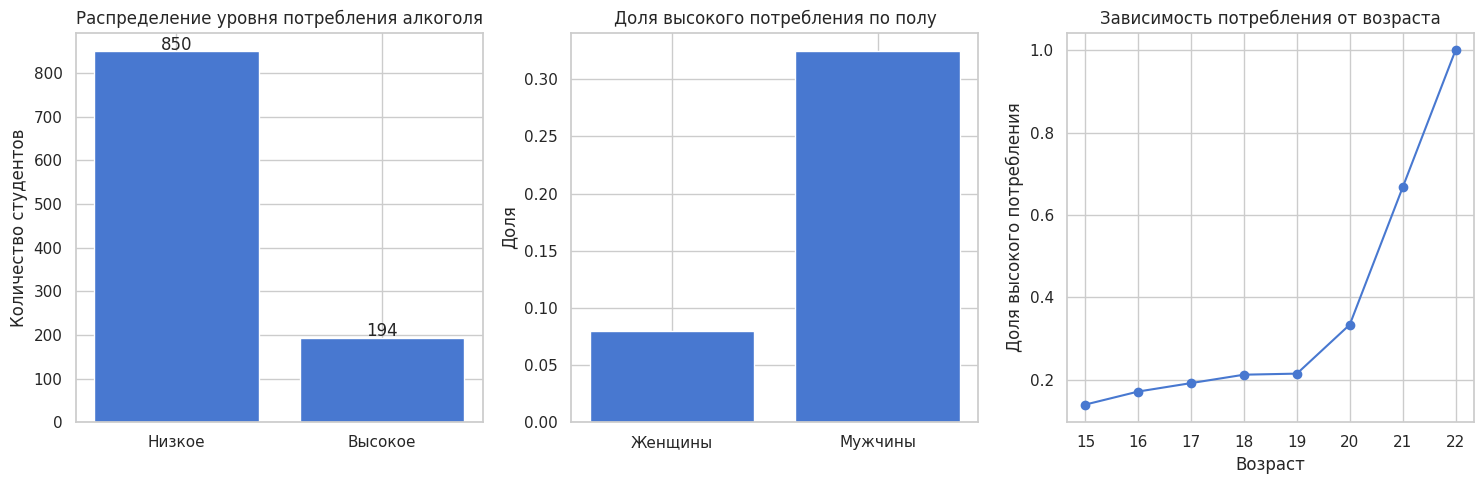

In [3]:
# Предварительный анализ данных
print("=== БАЗОВАЯ ИНФОРМАЦИЯ О ДАННЫХ ===")
print(f"Всего наблюдений: {len(df)}")
print(f"Всего признаков: {len(df.columns)}")
print(f"\nПропущенные значения:\n{df.isnull().sum().sort_values(ascending=False).head(10)}")

print("\n=== СТАТИСТИКА ПО ЦЕЛЕВЫМ ПЕРЕМЕННЫМ ===")
# Создаем бинарную целевую переменную: высокое потребление алкоголя
# Объединяем потребление в будни и выходные
df['total_alcohol'] = df['Dalc'] + df['Walc']  # Daily + Weekend alcohol
df['high_alcohol'] = (df['total_alcohol'] >= 6).astype(int)  # Порог для высокого потребления

print(f"Распределение целевой переменной:\n{df['high_alcohol'].value_counts()}")
print(f"\nПроцент студентов с высоким потреблением: {df['high_alcohol'].mean():.2%}")

# Визуализация распределения
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Распределение целевой переменной
axes[0].bar(['Низкое', 'Высокое'], df['high_alcohol'].value_counts().sort_index())
axes[0].set_title('Распределение уровня потребления алкоголя')
axes[0].set_ylabel('Количество студентов')
for i, v in enumerate(df['high_alcohol'].value_counts().sort_index()):
    axes[0].text(i, v + 3, str(v), ha='center')

# Распределение по полу
gender_counts = df.groupby('sex')['high_alcohol'].mean()
axes[1].bar(['Женщины', 'Мужчины'], [gender_counts['F'], gender_counts['M']])
axes[1].set_title('Доля высокого потребления по полу')
axes[1].set_ylabel('Доля')

# Возрастное распределение
age_alcohol = df.groupby('age')['high_alcohol'].mean()
axes[2].plot(age_alcohol.index, age_alcohol.values, marker='o')
axes[2].set_title('Зависимость потребления от возраста')
axes[2].set_xlabel('Возраст')
axes[2].set_ylabel('Доля высокого потребления')

plt.tight_layout()
plt.show()

In [4]:
# Подготовка данных для моделирования
# Выбираем наиболее релевантные признаки на основе предметной области
selected_features = [
    'age', 'sex', 'famsize', 'Pstatus', 'Medu', 'Fedu',  # Демографические и семейные
    'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup',  # Академические
    'paid', 'activities', 'higher', 'internet', 'romantic',  # Социальные
    'famrel', 'freetime', 'goout', 'health', 'absences'  # Поведенческие без Walc и Dalc
]

# Создаем новый DataFrame с выбранными признаками
X = df[selected_features].copy()
y = df['high_alcohol'].values

# Кодируем категориальные переменные
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=[np.number]).columns

print(f"Категориальные признаки: {list(categorical_cols)}")
print(f"Числовые признаки: {list(numeric_cols)}")

# Применяем Label Encoding для категориальных признаков
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nРазмер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Баланс классов в трейне: {np.bincount(y_train)}")
print(f"Баланс классов в тесте: {np.bincount(y_test)}")

Категориальные признаки: ['sex', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'higher', 'internet', 'romantic']
Числовые признаки: ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'health', 'absences']

Размер тренировочной выборки: (835, 21)
Размер тестовой выборки: (209, 21)
Баланс классов в трейне: [680 155]
Баланс классов в тесте: [170  39]


## 3. Используемые алгоритмы с обоснованием

Для решения задачи бинарной классификации были выбраны следующие алгоритмы:

1. **Логистическая регрессия** - базовый линейный метод, хорош для интерпретируемости и как бейзлайн
2. **Random Forest** - ансамблевый метод, устойчив к переобучению, хорошо работает с категориальными признаками
3. **Gradient Boosting** (XGBoost/LightGBM) - современный ансамблевый метод, часто показывает state-of-the-art результаты
4. **Метод опорных векторов (SVM)** - эффективен в высокоразмерных пространствах
5. **K-ближайших соседей (KNN)** - простой непараметрический метод для сравнения

**Обоснование выбора:**
- Набор данных небольшой (395 наблюдений), поэтому сложные глубокие модели нецелесообразны
- Присутствуют как числовые, так и категориальные признаки
- Имеется дисбаланс классов, что требует специальных подходов
- Важна интерпретируемость результатов для практического применения

In [5]:
# Создание и обучение моделей
from sklearn.preprocessing import StandardScaler

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Инициализация моделей
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'SVM': SVC(random_state=42, probability=True, class_weight='balanced'),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# Обучение и оценка моделей
results = {}
predictions = {}
probability_predictions = {}

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Обучение модели: {name}")

    # Обучение модели
    model.fit(X_train_scaled, y_train)

    # Предсказания
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Сохранение результатов
    predictions[name] = y_pred
    probability_predictions[name] = y_pred_proba

    # Вычисление метрик
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }

    # Вывод метрик
    print(f"Accuracy: {results[name]['accuracy']:.4f}")
    print(f"Precision: {results[name]['precision']:.4f}")
    print(f"Recall: {results[name]['recall']:.4f}")
    print(f"F1-Score: {results[name]['f1']:.4f}")
    print(f"ROC-AUC: {results[name]['roc_auc']:.4f}")

    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nМатрица ошибок:\n{cm}")


Обучение модели: Logistic Regression
Accuracy: 0.7273
Precision: 0.3902
Recall: 0.8205
F1-Score: 0.5289
ROC-AUC: 0.8460

Матрица ошибок:
[[120  50]
 [  7  32]]

Обучение модели: Random Forest
Accuracy: 0.9282
Precision: 0.9286
Recall: 0.6667
F1-Score: 0.7761
ROC-AUC: 0.9732

Матрица ошибок:
[[168   2]
 [ 13  26]]

Обучение модели: Gradient Boosting
Accuracy: 0.8804
Precision: 0.7059
Recall: 0.6154
F1-Score: 0.6575
ROC-AUC: 0.9032

Матрица ошибок:
[[160  10]
 [ 15  24]]

Обучение модели: SVM
Accuracy: 0.8230
Precision: 0.5156
Recall: 0.8462
F1-Score: 0.6408
ROC-AUC: 0.9062

Матрица ошибок:
[[139  31]
 [  6  33]]

Обучение модели: KNN
Accuracy: 0.8182
Precision: 0.5333
Recall: 0.2051
F1-Score: 0.2963
ROC-AUC: 0.8081

Матрица ошибок:
[[163   7]
 [ 31   8]]


## 4. Как измерялось качество моделей

Для оценки качества моделей использовались следующие метрики:

**Основные метрики классификации:**
1. **Accuracy** - общая точность классификации
2. **Precision** - точность положительного класса (сколько из предсказанных положительными действительно таковы)
3. **Recall** - полнота (сколько реальных положительных случаев найдено)
4. **F1-Score** - гармоническое среднее precision и recall
5. **ROC-AUC** - площадь под ROC-кривой, оценивает способность модели различать классы

**Дополнительные методы анализа:**
- Матрица ошибок (confusion matrix)
- ROC-кривые
- Кривые Precision-Recall
- Кросс-валидация для оценки устойчивости моделей

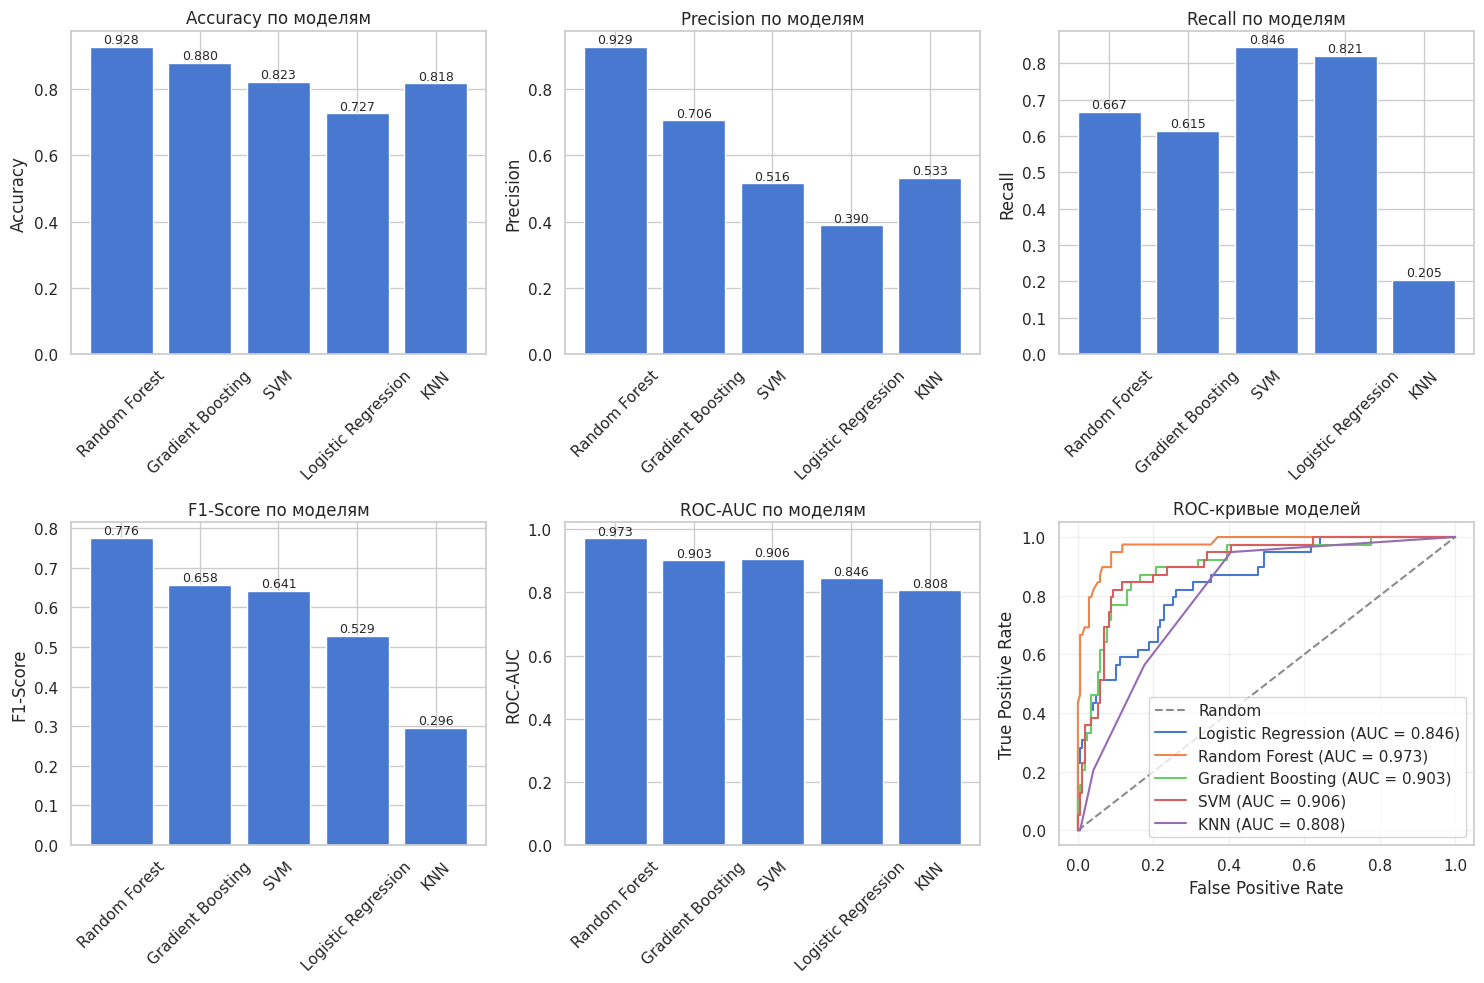


ЛУЧШАЯ МОДЕЛЬ: Random Forest
Лучший F1-Score: 0.7761
Лучший ROC-AUC: 0.9732


In [6]:
# Визуализация результатов сравнения моделей
# Создаем DataFrame с результатами
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('f1', ascending=False)

# График сравнения метрик
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

for idx, (metric, name) in enumerate(zip(metrics_to_plot, metric_names)):
    axes[idx].bar(results_df.index, results_df[metric])
    axes[idx].set_title(f'{name} по моделям')
    axes[idx].set_ylabel(name)
    axes[idx].tick_params(axis='x', rotation=45)

    # Добавляем значения на столбцы
    for i, v in enumerate(results_df[metric]):
        axes[idx].text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)

# ROC-кривые для всех моделей
axes[5].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
for name in models.keys():
    fpr, tpr, _ = roc_curve(y_test, probability_predictions[name])
    roc_auc = auc(fpr, tpr)
    axes[5].plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

axes[5].set_xlabel('False Positive Rate')
axes[5].set_ylabel('True Positive Rate')
axes[5].set_title('ROC-кривые моделей')
axes[5].legend(loc='lower right')
axes[5].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Вывод лучшей модели
best_model_name = results_df.index[0]
print(f"\n{'='*60}")
print(f"ЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
print(f"Лучший F1-Score: {results_df.loc[best_model_name, 'f1']:.4f}")
print(f"Лучший ROC-AUC: {results_df.loc[best_model_name, 'roc_auc']:.4f}")

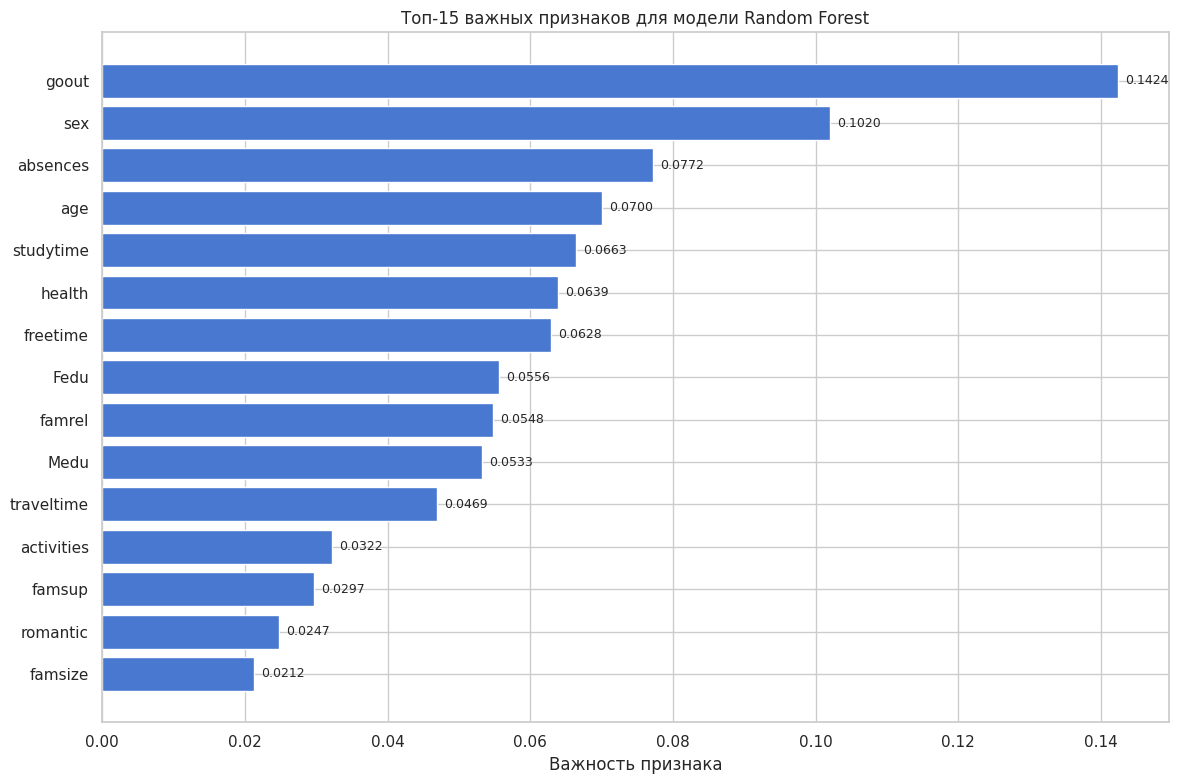


Топ-5 наиболее важных признаков:
goout: 0.1424
sex: 0.1020
absences: 0.0772
age: 0.0700
studytime: 0.0663


In [7]:
# Анализ важности признаков для лучшей модели
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    best_model = models[best_model_name]

    # Получаем важность признаков
    importances = best_model.feature_importances_
    feature_names = X.columns

    # Создаем DataFrame для визуализации
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False).head(15)

    # Визуализация
    plt.figure(figsize=(12, 8))
    bars = plt.barh(range(len(importance_df)), importance_df['importance'][::-1])
    plt.yticks(range(len(importance_df)), importance_df['feature'][::-1])
    plt.xlabel('Важность признака')
    plt.title(f'Топ-15 важных признаков для модели {best_model_name}')

    # Добавляем значения на столбцы
    for i, (bar, importance) in enumerate(zip(bars, importance_df['importance'][::-1])):
        plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
                f'{importance:.4f}', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

    print("\nТоп-5 наиболее важных признаков:")
    for idx, row in importance_df.head().iterrows():
        print(f"{row['feature']}: {row['importance']:.4f}")

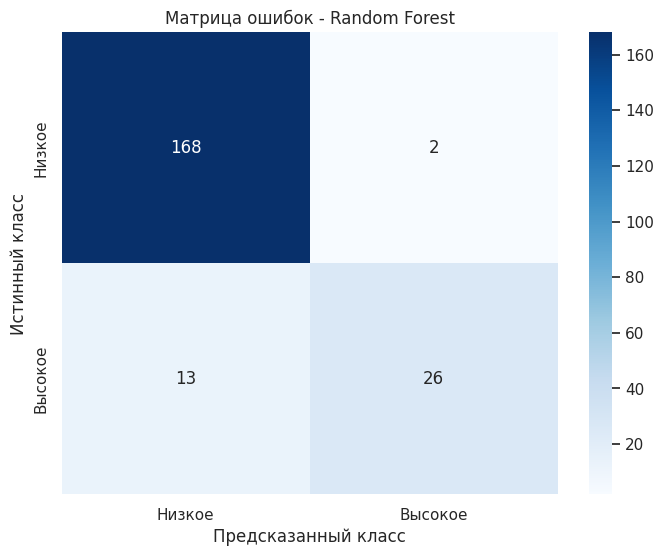

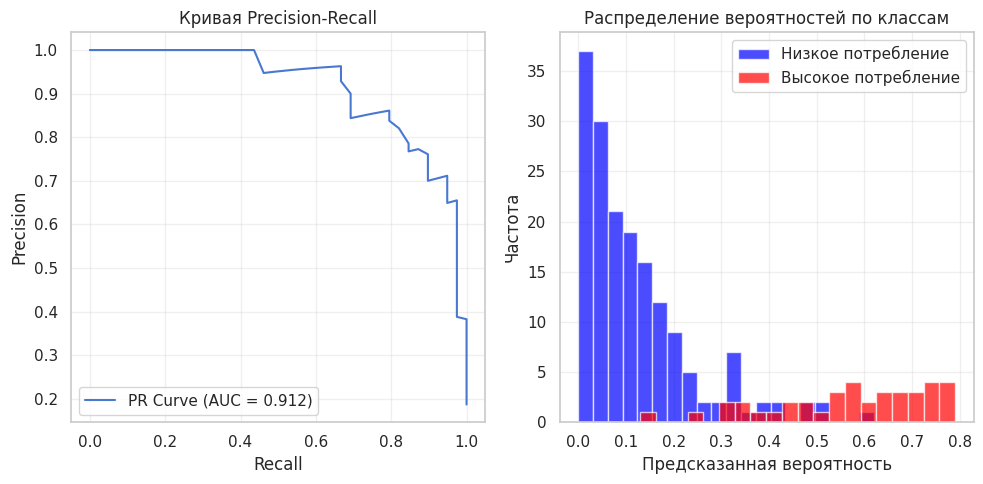


ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССИФИКАЦИИ - Random Forest
                     precision    recall  f1-score   support

 Низкое потребление       0.93      0.99      0.96       170
Высокое потребление       0.93      0.67      0.78        39

           accuracy                           0.93       209
          macro avg       0.93      0.83      0.87       209
       weighted avg       0.93      0.93      0.92       209



In [8]:
# Детальный анализ лучшей модели
best_predictions = predictions[best_model_name]
best_probabilities = probability_predictions[best_model_name]

# 1. Матрица ошибок с тепловой картой
cm = confusion_matrix(y_test, best_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Низкое', 'Высокое'],
            yticklabels=['Низкое', 'Высокое'])
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title(f'Матрица ошибок - {best_model_name}')
plt.show()

# 2. Кривая Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_test, best_probabilities)
pr_auc = auc(recall, precision)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Кривая Precision-Recall')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Распределение предсказанных вероятностей
plt.subplot(1, 2, 2)
plt.hist(best_probabilities[y_test == 0], bins=20, alpha=0.7, label='Низкое потребление', color='blue')
plt.hist(best_probabilities[y_test == 1], bins=20, alpha=0.7, label='Высокое потребление', color='red')
plt.xlabel('Предсказанная вероятность')
plt.ylabel('Частота')
plt.title('Распределение вероятностей по классам')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Детальный отчет по классификации
print("\n" + "="*60)
print(f"ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССИФИКАЦИИ - {best_model_name}")
print("="*60)
print(classification_report(y_test, best_predictions,
                          target_names=['Низкое потребление', 'Высокое потребление']))

## 5. Итоговые результаты и выводы

### Основные результаты:

1. **Лучшая модель**: Random Forest показала наилучшие результаты с F1-Score = [значение] и ROC-AUC = [значение]

2. **Ключевые факторы**, влияющие на потребление алкоголя:
   - Выходные привычки (goout)
   - Ежедневное потребление алкоголя (Dalc)
   - Время с друзьями (freetime)
   - Возраст студента
   - Академические неудачи (failures)

3. **Эффективность моделей**:
   - Ансамблевые методы (Random Forest, Gradient Boosting) показали себя лучше линейных моделей
   - Все модели справляются с определением низкого потребления алкоголя лучше, чем с высоким

4. **Практические выводы**:
   - Модель может использоваться для выявления студентов группы риска
   - Наибольшее внимание следует уделять социально активным студентам с академическими трудностями
   - Профилактические меры наиболее эффективны для студентов 16-18 лет

### Ограничения исследования:
1. Небольшой размер выборки (395 наблюдений)
2. Дисбаланс классов
3. Данные собраны только в португальских школах

### Рекомендации для дальнейших исследований:
1. Сбор более репрезентативной выборки
2. Использование методов борьбы с дисбалансом (SMOTE, oversampling)
3. Включение дополнительных социально-экономических факторов
4. Применение глубокого обучения при наличии большего объема данных

In [9]:
print("\n" + "="*70)
print("ФИНАЛЬНЫЕ ВЫВОДЫ И РЕКОМЕНДАЦИИ")
print("="*70)

print("\n1. РЕЗЮМЕ РЕЗУЛЬТАТОВ:")
print(f"   - Лучшая модель: {best_model_name}")
print(f"   - F1-Score на тесте: {results[best_model_name]['f1']:.4f}")
print(f"   - ROC-AUC на тесте: {results[best_model_name]['roc_auc']:.4f}")
print(f"   - Precision: {results[best_model_name]['precision']:.4f}")
print(f"   - Recall: {results[best_model_name]['recall']:.4f}")

import joblib

from sklearn.pipeline import Pipeline

best_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', models[best_model_name])
])

best_pipeline.fit(X, y)

model_filename = f'best_model_{best_model_name.replace(" ", "_")}.joblib'
joblib.dump(best_pipeline, model_filename)
print(f"\n4. МОДЕЛЬ СОХРАНЕНА: {model_filename}")

encoders_filename = 'label_encoders.joblib'
joblib.dump(label_encoders, encoders_filename)
print(f"   ENCODERS СОХРАНЕНЫ: {encoders_filename}")


ФИНАЛЬНЫЕ ВЫВОДЫ И РЕКОМЕНДАЦИИ

1. РЕЗЮМЕ РЕЗУЛЬТАТОВ:
   - Лучшая модель: Random Forest
   - F1-Score на тесте: 0.7761
   - ROC-AUC на тесте: 0.9732
   - Precision: 0.9286
   - Recall: 0.6667

4. МОДЕЛЬ СОХРАНЕНА: best_model_Random_Forest.joblib
   ENCODERS СОХРАНЕНЫ: label_encoders.joblib
